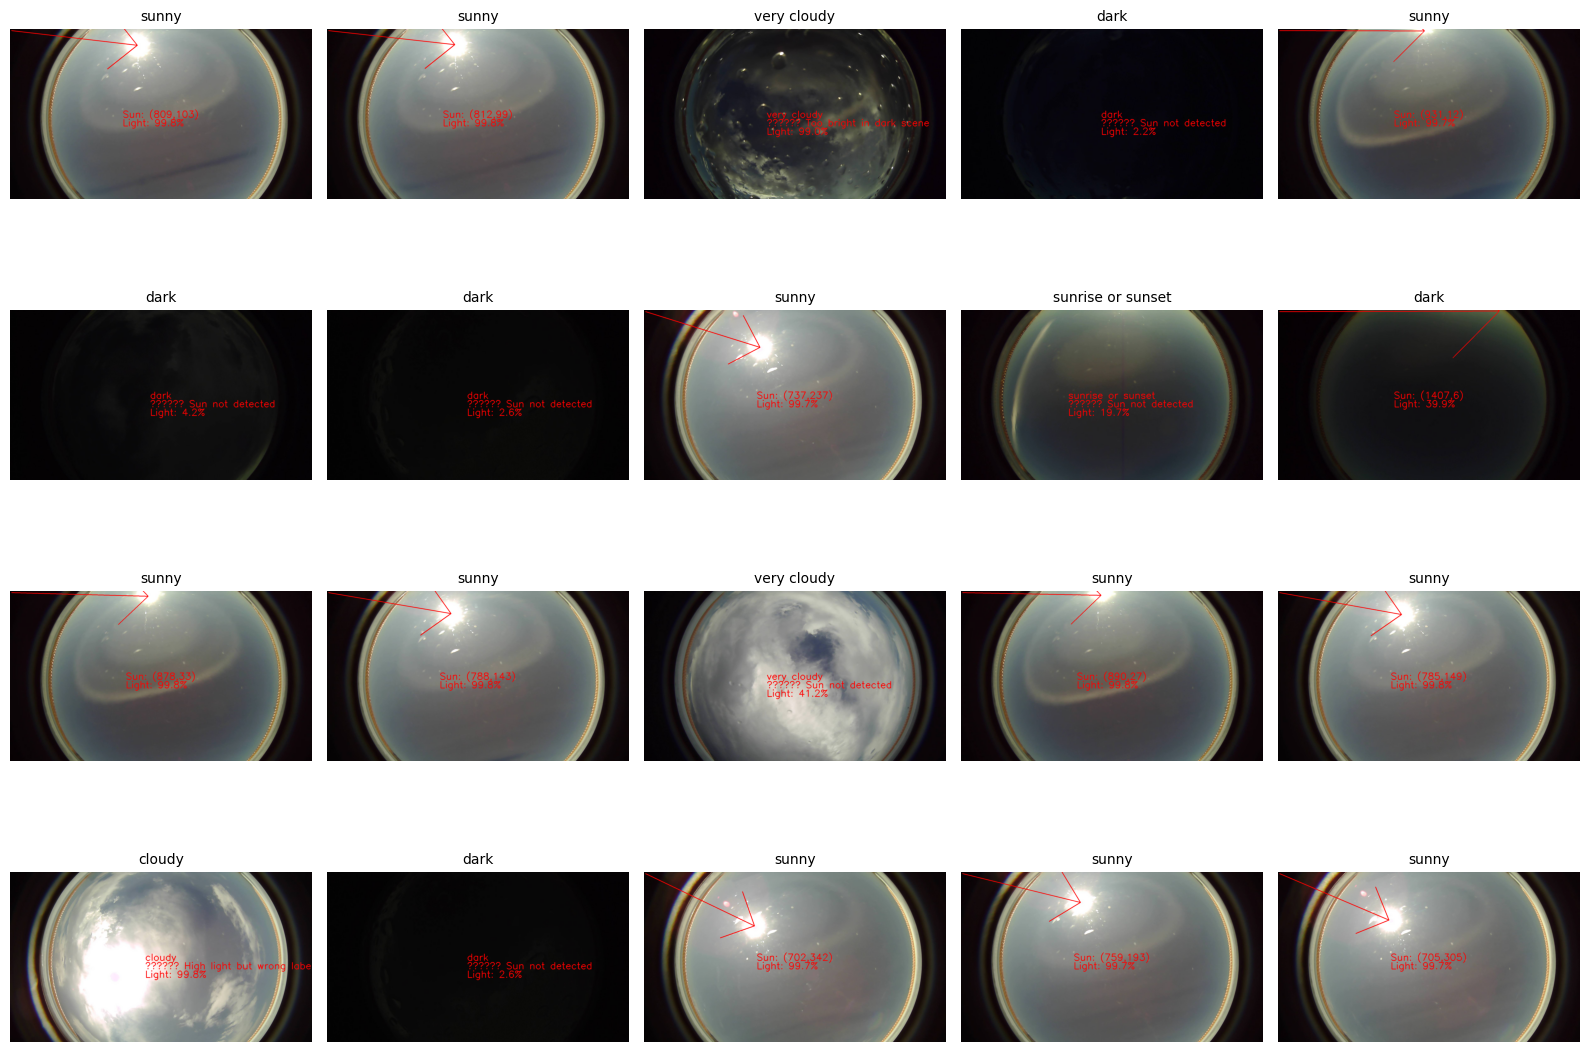

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Завантаження CSV з метаданими
df = pd.read_csv("sky_features.csv")  # змінюй на свій шлях, якщо потрібно

# === ФУНКЦІЯ ВИЯВЛЕННЯ СОНЦЯ ТА ОСВІТЛЕНОСТІ ===
def detect_sun_and_light_percent(img, label=None):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    scene_brightness = np.mean(gray)
    light_pct = scene_brightness / 255 * 100  # базова освітленість

    _, thresh = cv2.threshold(gray, int(0.98 * np.max(gray)), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cx, cy = 0, 0
    reason = "⚠️ Sun not detected"

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)

        if area >= 150:
            M = cv2.moments(largest_contour)
            if M["m00"] > 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Локальна освітленість у контурі
                mask = np.zeros_like(gray)
                cv2.drawContours(mask, [largest_contour], -1, 255, -1)
                light_pixels = gray[mask == 255]
                light_pct = np.mean(light_pixels) / 255 * 100

                # Фільтри на хибні виявлення (але НЕ зануляємо освітленість)
                if scene_brightness < 50 and light_pct > 90:
                    reason = "⚠️ Too bright in dark scene"
                    cx, cy = 0, 0
                elif label in ['dark', 'very cloudy', 'cloudy'] and light_pct > 90:
                    reason = "⚠️ High light but wrong label"
                    cx, cy = 0, 0
                else:
                    reason = None  # все добре — можна малювати Сонце

    return (cx, cy), light_pct, reason


# === ВІЗУАЛІЗАЦІЯ 20 ЗОБРАЖЕНЬ ===
sample = df.sample(20, random_state=42)

plt.figure(figsize=(16, 12))

for i, row in enumerate(sample.itertuples()):
    path = os.path.join("images", row.label, os.path.basename(row.filename))
    img = cv2.imread(path)

    if img is None:
        print(f"⚠️ Пропущено: {path}")
        continue

    sun_pos, light_pct, reason = detect_sun_and_light_percent(img, label=row.label)
    h, w = img.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.0
    thickness = 4

    if reason is None:
        # Покажемо стрілку до Сонця
        x, y = sun_pos
        cv2.arrowedLine(img, (10, 10), (x, y), (0, 0, 255), 3, tipLength=0.3)
        text = f"Sun: ({x},{y})\nLight: {light_pct:.1f}%"
    else:
        # Без стрілки, тільки освітленість і пояснення
        text = f"{row.label}\n{reason}\nLight: {light_pct:.1f}%"

    # Центрування підпису
    (tw, th), _ = cv2.getTextSize(text.split('\n')[0], font, font_scale, thickness)
    x_text = (w - tw) // 2
    y_text = (h + th) // 2
    for j, line in enumerate(text.split('\n')):
        y_offset = y_text + j * (th + 10)
        cv2.putText(img, line, (x_text, y_offset), font, font_scale, (0, 0, 255), thickness)

    # Вивід
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"{row.label}", fontsize=10)

plt.tight_layout()
plt.show()
